# Librerias

In [1]:
import torch
torch.cuda.empty_cache()

In [2]:
!nvidia-smi

Fri Apr  2 09:48:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 00000001:00:00.0 Off |                    0 |
| N/A   56C    P8    59W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           On   | 00000002:00:00.0 Off |                    0 |
| N/A   

In [3]:
%%capture 
!pip install transformers -U
#!pip install pytorch

In [4]:
!pip show transformers

Name: transformers
Version: 4.4.2
Summary: State-of-the-art Natural Language Processing for TensorFlow 2.0 and PyTorch
Home-page: https://github.com/huggingface/transformers
Author: Thomas Wolf, Lysandre Debut, Victor Sanh, Julien Chaumond, Sam Shleifer, Patrick von Platen, Sylvain Gugger, Google AI Language Team Authors, Open AI team Authors, Facebook AI Authors, Carnegie Mellon University Authors
Author-email: thomas@huggingface.co
License: Apache
Location: /anaconda/envs/py37_pytorch/lib/python3.7/site-packages
Requires: requests, tqdm, sacremoses, numpy, packaging, regex, tokenizers, filelock, importlib-metadata
Required-by: bertviz


In [5]:
from sklearn.model_selection import train_test_split
import torch

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
%%capture
!pip install wandb
import wandb
wandb.login()

In [8]:
wandb.login()

True

# Carga de datos
- incluidas nuevas columnas con concatenacion de review_body y categoria, review_body y titulo
- nuevos indices para star rating, de 0-4 en vez de 1-5
- numericalizar las categorias de los productos, 31 en total

Para TRAIN:
  - data ingles EN 
  - data aleman DE

Para VALID Y TEST:
  - data en ingles EN
  - data en aleman DE
  - data en español ES
  - data en francés FR
  - data en japones JA
  - data en chino ZH

In [9]:
# Load data
import pandas as pd

## Para TRAIN, en ingles
path1 = "amazonEN_train.csv"

## Para VALID, en ingles
path2 = "amazonEN_valid.csv"

## Para TEST, en ingles, aleman, español, frances, japones y chino
path3 = "amazonDE_test.csv"

####### CONVERTIMOS A DATAFRAMES #########

df_train = pd.read_csv(path1)
df_train = df_train

df_valid = pd.read_csv(path2)
df_valid = df_valid

df_test = pd.read_csv(path3)
df_test = df_test

In [10]:
df_train.head(1)

,review_id,product_id,reviewer_id,star_rating,review_body,review_title,language,product_category,text_title,text_title_cat,text_cat,product_category_cod
0,en_0953486,product_en_0381770,reviewer_en_0978532,4,"Great, great batteries. Arrived on time and pa...",Strip of 10 Fresh Maxell LR1130 Batteries,en,electronics,Strip of 10 Fresh Maxell LR1130 Batteries Grea...,Strip of 10 Fresh Maxell LR1130 Batteries Grea...,"Great, great batteries. Arrived on time and pa...",9


# Carga modelo mBERT
- incluye tokenizer

In [10]:
PRE_TRAINED_MODEL_NAME = 'bert-base-multilingual-cased'
from transformers import BertModel, BertConfig, BertTokenizer
from transformers import BertForSequenceClassification
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

# mBertForSequenceClassification - RATING
- Clasificación Rating a partir de review_body

In [11]:
%env WANDB_PROJECT = RATING CLASSIFICATION mBERT 

env: WANDB_PROJECT=RATING CLASSIFICATION mBERT


In [12]:
%env WANDB_WATCH = 'all'

env: WANDB_WATCH='all'


In [14]:
RANDOM_SEED=8
MAX_LENGTH=260


## CLASES DEL CLASIFICADOR 

class_names = ['0','1','2','3','4'] 

In [15]:
RANDOM_SEED=8
MAX_LENGTH=260


train_encodings = tokenizer(df_train.review_body.values.tolist(), #truncation=True, padding=True,
      add_special_tokens=True,
      truncation=True,
      max_length=MAX_LENGTH,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt')

val_encodings = tokenizer(df_valid.review_body.values.tolist(), #truncation=True, padding=True,
      add_special_tokens=True,
      truncation=True,
      max_length=MAX_LENGTH,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt')

test_encodings = tokenizer(df_test.review_body.values.tolist(), #truncation=True, padding=True,
      add_special_tokens=True,
      truncation=True,
      max_length=MAX_LENGTH,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt')

In [16]:
class AMZReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [17]:
train_labels = df_train.star_rating.values
val_labels = df_valid.star_rating.values
test_labels = df_test.star_rating.values

In [18]:
train_data = AMZReviewDataset(train_encodings, torch.from_numpy(train_labels))
val_data = AMZReviewDataset(val_encodings, torch.from_numpy(val_labels))
test_data = AMZReviewDataset(test_encodings, torch.from_numpy(test_labels))

In [19]:
from transformers import BertForSequenceClassification

## DEFINIMOS EL MODELO 

model = BertForSequenceClassification.from_pretrained(
    PRE_TRAINED_MODEL_NAME,         # Use the 12-layer BERT model, with an uncased vocab.
    #'Chek4mv_multi',
    num_labels = len(class_names),  # The number of output labels--2 for binary classification.
    output_attentions = False,      # Whether the model returns attentions weights.
    output_hidden_states = False ,  # Whether the model returns all hidden-states.   
    vocab_size=tokenizer.vocab_size)

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [21]:
device

device(type='cuda', index=0)

## Training

In [15]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [36]:
#from datasets import load_metric
#import numpy as np

#accuracy_metric = load_metric("accuracy")

#def compute_metrics(eval_pred):
 #   predictions, labels = eval_pred
  #  predictions = np.argmax(predictions, axis=1)
    # metrics from the datasets library have a `compute` method
    #  return accuracy_metric.compute(predictions=predictions, references=labels)

In [22]:
model_dir="./"

from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir = model_dir +  'prueba/results',          # output directory
    overwrite_output_dir = True,
    evaluation_strategy='epoch',
    num_train_epochs=3,                  # total number of training epochs
    per_device_train_batch_size=8,       # batch size per device during training
    per_device_eval_batch_size=16,       # batch size for evaluation
    warmup_steps=500,                    # number of warmup steps for learning rate scheduler
    weight_decay=0.01,                   # strength of weight decay
    logging_dir = model_dir +  'prueba/logs',       # directory for storing logs
    logging_steps=10,
    load_best_model_at_end = True,
    #report_to = 'wandb',                # enable logging to W&B
    run_name = 'EN - DE'                 # name of the W&B run
)

trainer = Trainer(
    model = model,                         # the instantiated 🤗 Transformers model to be trained
    args = training_args,                  # training arguments, defined above
    train_dataset = train_data,            # training dataset
    eval_dataset = test_data,              # evaluation dataset
    compute_metrics=compute_metrics            
)

trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
1,0.976000,1.019836,0.554400,0.557216,0.566414,0.554400,92.529800,27.018000


RuntimeError: Caught RuntimeError in replica 1 on device 1.
Original Traceback (most recent call last):
  File "/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/torch/nn/parallel/parallel_apply.py", line 61, in _worker
    output = module(*input, **kwargs)
  File "/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/torch/nn/modules/module.py", line 727, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/transformers/models/bert/modeling_bert.py", line 1510, in forward
    return_dict=return_dict,
  File "/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/torch/nn/modules/module.py", line 727, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/transformers/models/bert/modeling_bert.py", line 981, in forward
    return_dict=return_dict,
  File "/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/torch/nn/modules/module.py", line 727, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/transformers/models/bert/modeling_bert.py", line 575, in forward
    output_attentions,
  File "/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/torch/nn/modules/module.py", line 727, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/transformers/models/bert/modeling_bert.py", line 497, in forward
    self.feed_forward_chunk, self.chunk_size_feed_forward, self.seq_len_dim, attention_output
  File "/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/transformers/modeling_utils.py", line 1819, in apply_chunking_to_forward
    return forward_fn(*input_tensors)
  File "/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/transformers/models/bert/modeling_bert.py", line 508, in feed_forward_chunk
    intermediate_output = self.intermediate(attention_output)
  File "/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/torch/nn/modules/module.py", line 727, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/transformers/models/bert/modeling_bert.py", line 412, in forward
    hidden_states = self.intermediate_act_fn(hidden_states)
  File "/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/torch/nn/functional.py", line 1383, in gelu
    return torch._C._nn.gelu(input)
RuntimeError: CUDA out of memory. Tried to allocate 48.00 MiB (GPU 1; 11.17 GiB total capacity; 7.27 GiB already allocated; 27.44 MiB free; 7.38 GiB reserved in total by PyTorch)


In [23]:
model_path = "Chek1mv_multi"
trainer.save_model(model_path)
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('Chek1mv_multi/tokenizer_config.json',
 'Chek1mv_multi/special_tokens_map.json',
 'Chek1mv_multi/vocab.txt',
 'Chek1mv_multi/added_tokens.json')

In [49]:
model_dir="./"

from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir = model_dir +  'prueba/results',          # output directory
    overwrite_output_dir = True,
    evaluation_strategy='epoch',
    num_train_epochs=1,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir = model_dir +  'prueba/logs',            # directory for storing logs
    logging_steps=10,
    load_best_model_at_end = True,
    #report_to = 'wandb',           # enable logging to W&B
    run_name = 'EN - DE'   # name of the W&B run
)

trainer = Trainer(
    model = model,                         # the instantiated 🤗 Transformers model to be trained
    args = training_args,                  # training arguments, defined above
    train_dataset = train_data,           # training dataset
    eval_dataset = test_data,             # evaluation dataset
    compute_metrics=compute_metrics            
)

trainer.train("drive/MyDrive/TFG_1/Checkpoints/Chek1mv_multi")

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
1,0.913100,0.950955,0.577200,0.572664,0.571422,0.577200,43.394300,57.611000


TrainOutput(global_step=6250, training_loss=1.0368619778442383, metrics={'train_runtime': 11804.8167, 'train_samples_per_second': 0.529, 'total_flos': 5.549147292e+16, 'epoch': 1.0, 'init_mem_cpu_alloc_delta': 2106217, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 1064799839, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 12892669, 'train_mem_gpu_alloc_delta': 2885308928, 'train_mem_cpu_peaked_delta': 734423176, 'train_mem_gpu_peaked_delta': 3937049088})

In [51]:
model_path = "Chek2mv_multi"
trainer.save_model(model_path)
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('Chek2mv_multi/tokenizer_config.json',
 'Chek2mv_multi/special_tokens_map.json',
 'Chek2mv_multi/vocab.txt',
 'Chek2mv_multi/added_tokens.json')

In [21]:
model_dir="./"

from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir = model_dir +  'prueba/results',          # output directory
    overwrite_output_dir = True,
    evaluation_strategy='epoch',
    num_train_epochs=1,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir = model_dir +  'prueba/logs',            # directory for storing logs
    logging_steps=10,
    load_best_model_at_end = True,
    #report_to = 'wandb',           # enable logging to W&B
    run_name = 'EN - DE'   # name of the W&B run
)

trainer = Trainer(
    model = model,                         # the instantiated 🤗 Transformers model to be trained
    args = training_args,                  # training arguments, defined above
    train_dataset = train_data,           # training dataset
    eval_dataset = test_data,             # evaluation dataset
    compute_metrics=compute_metrics            
)

trainer.train("drive/MyDrive/TFG_1/Checkpoints/Chek2mv_multi")

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
1,0.917800,0.948830,0.580800,0.576185,0.574535,0.580800,43.431200,57.562000


TrainOutput(global_step=6250, training_loss=1.038168766479492, metrics={'train_runtime': 11889.265, 'train_samples_per_second': 0.526, 'total_flos': 5.549147292e+16, 'epoch': 1.0, 'init_mem_cpu_alloc_delta': 67058, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 18306, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 13316381, 'train_mem_gpu_alloc_delta': 2884997632, 'train_mem_cpu_peaked_delta': 734412258, 'train_mem_gpu_peaked_delta': 3937049088})

In [22]:
model_path = "Chek3mv_multi"
trainer.save_model(model_path)
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('Chek3mv_multi/tokenizer_config.json',
 'Chek3mv_multi/special_tokens_map.json',
 'Chek3mv_multi/vocab.txt',
 'Chek3mv_multi/added_tokens.json')

In [22]:
model_dir="./"

from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir = model_dir +  'prueba/results',          # output directory
    overwrite_output_dir = True,
    evaluation_strategy='epoch',
    num_train_epochs=2,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir = model_dir +  'prueba/logs',            # directory for storing logs
    logging_steps=10,
    load_best_model_at_end = True,
    #report_to = 'wandb',           # enable logging to W&B
    run_name = 'EN - DE'   # name of the W&B run
)

trainer = Trainer(
    model = model,                         # the instantiated 🤗 Transformers model to be trained
    args = training_args,                  # training arguments, defined above
    train_dataset = train_data,           # training dataset
    eval_dataset = test_data,             # evaluation dataset
    compute_metrics=compute_metrics            
)

trainer.train("Chek3mv_multi")

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
1,0.976200,0.970453,0.577600,0.570336,0.571102,0.577600,43.424900,57.571000
2,0.834500,0.952905,0.588400,0.585299,0.583591,0.588400,43.285700,57.756000


TrainOutput(global_step=12500, training_loss=0.8972144152832031, metrics={'train_runtime': 23774.2108, 'train_samples_per_second': 0.526, 'total_flos': 1.1098294584e+17, 'epoch': 2.0, 'init_mem_cpu_alloc_delta': 67058, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 18306, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 27065773, 'train_mem_gpu_alloc_delta': 3597020160, 'train_mem_cpu_peaked_delta': 734496426, 'train_mem_gpu_peaked_delta': 3937049088})

In [23]:
model_path = "Chek4mv_multi"
trainer.save_model(model_path)
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('Chek4mv_multi/tokenizer_config.json',
 'Chek4mv_multi/special_tokens_map.json',
 'Chek4mv_multi/vocab.txt',
 'Chek4mv_multi/added_tokens.json')

In [45]:
#wandb.init(project="mBERT", 
#                name = "mbert",
#                tags = ['rating'],
#                group = "mbert_body_rating")

In [23]:
model_dir="./"

from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir = model_dir +  'prueba/results',          # output directory
    overwrite_output_dir = True,
    evaluation_strategy='epoch',
    num_train_epochs=2,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir = model_dir +  'prueba/logs',            # directory for storing logs
    logging_steps=10,
    load_best_model_at_end = True,
    #report_to = 'wandb',           # enable logging to W&B
    run_name = 'EN - DE'   # name of the W&B run
)

trainer = Trainer(
    model = model,                         # the instantiated 🤗 Transformers model to be trained
    args = training_args,                  # training arguments, defined above
    train_dataset = train_data,           # training dataset
    eval_dataset = test_data,             # evaluation dataset
    compute_metrics=compute_metrics            
)

trainer.train("Chek4mv_multi")

wandb: wandb version 0.10.24 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
1,0.976200,0.970453,0.577600,0.570336,0.571102,0.577600,44.906200,55.672000
2,0.834500,0.952905,0.588400,0.585299,0.583591,0.588400,44.712400,55.913000


TrainOutput(global_step=12500, training_loss=0.8972144152832031, metrics={'train_runtime': 24049.5862, 'train_samples_per_second': 0.52, 'total_flos': 1.1098294584e+17, 'epoch': 2.0, 'init_mem_cpu_alloc_delta': 66919, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 18306, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 27071605, 'train_mem_gpu_alloc_delta': 3597020160, 'train_mem_cpu_peaked_delta': 734495907, 'train_mem_gpu_peaked_delta': 3937049088})

## Evaluation sobre dato en idioma de entrenamiento (inglés)

In [ ]:
trainer.evaluate()

## Test sobre dato en otros idiomas

              precision    recall  f1-score   support

           0       0.63      0.40      0.49       479
           1       0.38      0.44      0.41       513
           2       0.34      0.58      0.43       512
           3       0.42      0.42      0.42       493
           4       0.70      0.34      0.46       503

    accuracy                           0.44      2500
   macro avg       0.50      0.43      0.44      2500
weighted avg       0.49      0.44      0.44      2500

{'eval_loss': 1.3517433404922485, 'eval_accuracy': 0.4356, 'eval_f1': 0.43968140412768236, 'eval_precision': 0.49308058527736137, 'eval_recall': 0.4356, 'eval_runtime': 43.3109, 'eval_samples_per_second': 57.722, 'test_mem_cpu_alloc_delta': 170463, 'test_mem_gpu_alloc_delta': 0, 'test_mem_cpu_peaked_delta': 766274, 'test_mem_gpu_peaked_delta': 773972480}


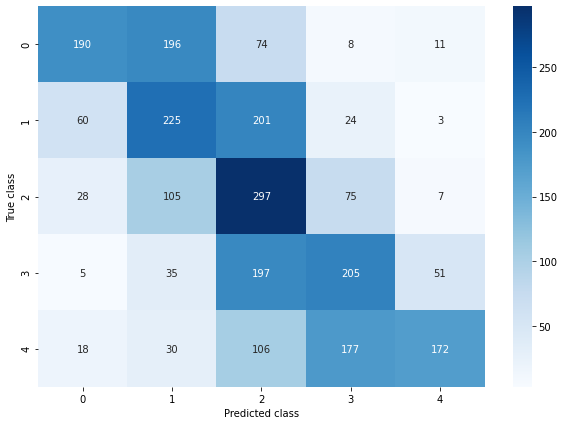

In [25]:
## Función test dato  
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# El metodo predict devuelve array con predicciones, las labels del test data y las métricas del test

#Aleman 
predictions,labels, metrics = trainer.predict(val_data)  

matrix = confusion_matrix(labels, predictions.argmax(axis=1))

plt.figure(figsize = (10,7))
## Confusion matrix with counts
sns.heatmap(matrix, annot=True,cmap='Blues',fmt='g')

#sns.heatmap(matrix/np.sum(matrix), annot=True, 
#          fmt='.2%', cmap='Oranges')
plt.xlabel("Predicted class")
plt.ylabel("True class") 

clas_report = classification_report(labels, predictions.argmax(axis=1))

print(clas_report)
print(metrics)

In [27]:
#Test Dato español  

path3 = "amazonES_valid.csv"
df_valid = pd.read_csv(path3)
df_valid = df_valid

val_encodings = tokenizer(df_valid.text_title.values.tolist(), #truncation=True, padding=True,
      add_special_tokens=True,
      truncation=True,
      max_length=MAX_LENGTH,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt')

val_labels = df_valid.star_rating.values
val_data_ES = GPReviewDataset(val_encodings, torch.from_numpy(val_labels))

              precision    recall  f1-score   support

           0       0.67      0.55      0.61       502
           1       0.43      0.36      0.39       503
           2       0.41      0.49      0.44       497
           3       0.45      0.43      0.44       503
           4       0.61      0.72      0.66       495

    accuracy                           0.51      2500
   macro avg       0.51      0.51      0.51      2500
weighted avg       0.51      0.51      0.51      2500

{'eval_loss': 1.1444693803787231, 'eval_accuracy': 0.51, 'eval_f1': 0.508005889817473, 'eval_precision': 0.5130164858438848, 'eval_recall': 0.51, 'eval_runtime': 43.4588, 'eval_samples_per_second': 57.526, 'test_mem_cpu_alloc_delta': 174707, 'test_mem_gpu_alloc_delta': 0, 'test_mem_cpu_peaked_delta': 763885, 'test_mem_gpu_peaked_delta': 773972480}


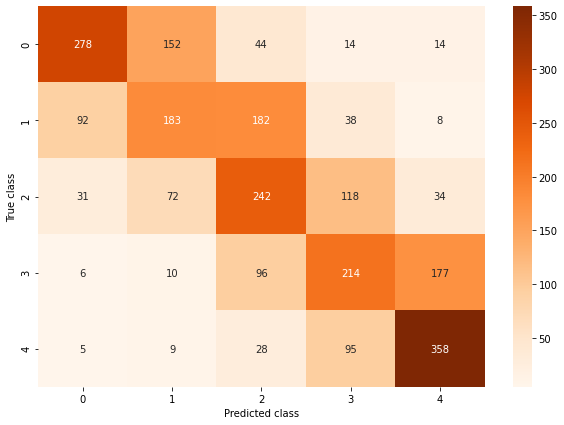

In [28]:
## valid data en ESPAÑOL
predictions,labels, metrics = trainer.predict(val_data_ES)  

# MATRIZ DE CONFUSION
matrix = confusion_matrix(labels, predictions.argmax(axis=1))

plt.figure(figsize = (10,7))
## Confusion matrix with counts
sns.heatmap(matrix, annot=True,cmap='Oranges',fmt='g')

#sns.heatmap(matrix/np.sum(matrix), annot=True, 
#          fmt='.2%', cmap='Oranges')
plt.xlabel("Predicted class")
plt.ylabel("True class") 

clas_report = classification_report(labels, predictions.argmax(axis=1))

print(clas_report)
print(metrics)

In [29]:
#Test Dato frances  

path3 = "amazonFR_valid.csv"
df_valid = pd.read_csv(path3)
df_valid = df_valid

val_encodings = tokenizer(df_valid.text_title.values.tolist(), #truncation=True, padding=True,
      add_special_tokens=True,
      truncation=True,
      max_length=MAX_LENGTH,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt')

val_labels = df_valid.star_rating.values
val_data_FR = GPReviewDataset(val_encodings, torch.from_numpy(val_labels))

              precision    recall  f1-score   support

           0       0.64      0.54      0.59       503
           1       0.41      0.33      0.36       490
           2       0.35      0.43      0.39       493
           3       0.41      0.46      0.44       512
           4       0.62      0.61      0.61       502

    accuracy                           0.48      2500
   macro avg       0.49      0.47      0.48      2500
weighted avg       0.49      0.48      0.48      2500

{'eval_loss': 1.2378034591674805, 'eval_accuracy': 0.4756, 'eval_f1': 0.4779166914729096, 'eval_precision': 0.4861928983438436, 'eval_recall': 0.4756, 'eval_runtime': 43.4094, 'eval_samples_per_second': 57.591, 'test_mem_cpu_alloc_delta': 171537, 'test_mem_gpu_alloc_delta': 0, 'test_mem_cpu_peaked_delta': 768049, 'test_mem_gpu_peaked_delta': 773972480}


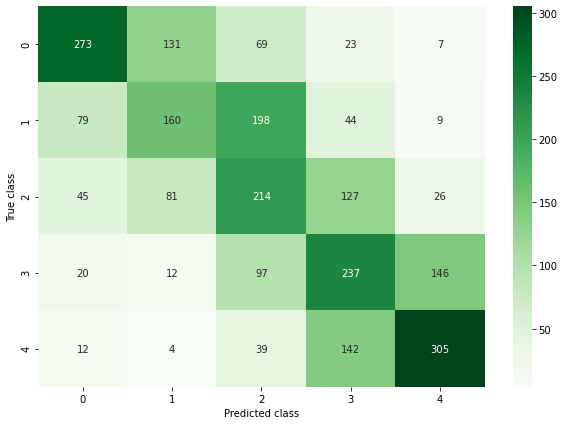

In [30]:
## valid data en FRANCES
predictions,labels, metrics = trainer.predict(val_data_FR)  

# MATRIZ DE CONFUSION
matrix = confusion_matrix(labels, predictions.argmax(axis=1))

plt.figure(figsize = (10,7))
## Confusion matrix with counts
sns.heatmap(matrix, annot=True,cmap='Greens',fmt='g')

#sns.heatmap(matrix/np.sum(matrix), annot=True, 
#          fmt='.2%', cmap='Oranges')
plt.xlabel("Predicted class")
plt.ylabel("True class") 

clas_report = classification_report(labels, predictions.argmax(axis=1))

print(clas_report)
print(metrics)

## Save Model final

In [ ]:
!ls drive/MyDrive/TFG_1/Modelos_entrenados/

In [ ]:
# saving the fine tuned model & tokenizer
model_path = "Rating_text_mBERT_final"
trainer.save_model(model_path)
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

# mBertForSequenceClassification - RATING
- Clasificación Rating a partir de review_body + titulo

In [15]:
RANDOM_SEED=8
MAX_LENGTH=260


## CLASES DEL CLASIFICADOR 

class_names = ['0','1','2','3','4'] 

In [16]:
#TOKENIZAMOS LOS DATAFRAMES

train_encodings = tokenizer(df_train.text_title.values.tolist(), #truncation=True, padding=True,
      add_special_tokens=True,
      truncation=True,
      max_length=MAX_LENGTH,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt')

val_encodings = tokenizer(df_valid.text_title.values.tolist(), #truncation=True, padding=True,
      add_special_tokens=True,
      truncation=True,
      max_length=MAX_LENGTH,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt')

test_encodings = tokenizer(df_test.text_title.values.tolist(), #truncation=True, padding=True,
      add_special_tokens=True,
      truncation=True,
      max_length=MAX_LENGTH,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt')

In [17]:
class GPReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [18]:
train_labels = df_train.star_rating.values
val_labels = df_valid.star_rating.values
test_labels = df_test.star_rating.values

In [19]:
train_data = GPReviewDataset(train_encodings, torch.from_numpy(train_labels))
val_data = GPReviewDataset(val_encodings, torch.from_numpy(val_labels))
test_data = GPReviewDataset(test_encodings, torch.from_numpy(test_labels))

In [20]:
## Lo definimos de nuevo unicamente con el proposito de usar las secciones del documento de forma independiente 

model = BertForSequenceClassification.from_pretrained(
    PRE_TRAINED_MODEL_NAME, # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = len(class_names), # The number of output labels--2 for binary classification.  si pones num_labels=1 hace MSE LOSS
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False ,# Whether the model returns all hidden-states.   
    vocab_size=tokenizer.vocab_size)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

## Training

In [20]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [24]:
model_dir="./"

from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir = model_dir +  'prueba/results',          # output directory
    overwrite_output_dir = True,
    evaluation_strategy='epoch',
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir = model_dir +  'prueba/logs',            # directory for storing logs
    logging_steps=10,
    load_best_model_at_end = True,
    #report_to = 'wandb',           # enable logging to W&B
    run_name = 'EN-body_title-rating'   # name of the W&B run
)

trainer = Trainer(
    model = model,                         # the instantiated 🤗 Transformers model to be trained
    args = training_args,                  # training arguments, defined above
    train_dataset = train_data,            # training dataset en inles
    eval_dataset = val_data,               # evaluation dataset en ingles
    compute_metrics=compute_metrics                   
)

trainer.train()

wandb: wandb version 0.10.24 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
1,0.801600,0.852742,0.636800,0.638591,0.648434,0.636800,44.720100,55.903000
2,0.772600,0.838883,0.636400,0.635148,0.642136,0.636400,44.528500,56.144000
3,0.680500,0.857142,0.646400,0.646676,0.647721,0.646400,44.380000,56.332000


TrainOutput(global_step=18750, training_loss=0.789291808573405, metrics={'train_runtime': 36263.617, 'train_samples_per_second': 0.517, 'total_flos': 1.6647441876e+17, 'epoch': 3.0, 'init_mem_cpu_alloc_delta': 67058, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 18306, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 40806060, 'train_mem_gpu_alloc_delta': 2884997632, 'train_mem_cpu_peaked_delta': 734428000, 'train_mem_gpu_peaked_delta': 3937049088})

In [25]:
model_path = "Chek1mv_multi_2"
trainer.save_model(model_path)
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('Chek1mv_multi_2/tokenizer_config.json',
 'Chek1mv_multi_2/special_tokens_map.json',
 'Chek1mv_multi_2/vocab.txt',
 'Chek1mv_multi_2/added_tokens.json')

## Evaluation en ingles

In [26]:
trainer.evaluate()

wandb: WARNING Step must only increase in log calls.  Step 18750 < 18751; dropping {'eval/loss': 0.8388826251029968, 'eval/accuracy': 0.6364, 'eval/f1': 0.6351479462238594, 'eval/precision': 0.6421361654494046, 'eval/recall': 0.6364, 'eval/runtime': 44.3356, 'eval/samples_per_second': 56.388, 'train/epoch': 3.0}.


{'eval_loss': 0.8388826251029968,
 'eval_accuracy': 0.6364,
 'eval_f1': 0.6351479462238594,
 'eval_precision': 0.6421361654494046,
 'eval_recall': 0.6364,
 'eval_runtime': 44.3356,
 'eval_samples_per_second': 56.388,
 'epoch': 3.0,
 'eval_mem_cpu_alloc_delta': 180146,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_cpu_peaked_delta': 756197,
 'eval_mem_gpu_peaked_delta': 773972480}

## Test en otros idiomas

              precision    recall  f1-score   support

           0       0.71      0.42      0.53       521
           1       0.36      0.42      0.39       487
           2       0.30      0.76      0.43       488
           3       0.40      0.19      0.26       507
           4       0.74      0.24      0.37       497

    accuracy                           0.40      2500
   macro avg       0.50      0.41      0.39      2500
weighted avg       0.51      0.40      0.39      2500

{'eval_loss': 1.4870661497116089, 'eval_accuracy': 0.4036, 'eval_f1': 0.39486898418167027, 'eval_precision': 0.5066604560258099, 'eval_recall': 0.4036, 'eval_runtime': 44.5045, 'eval_samples_per_second': 56.174, 'test_mem_cpu_alloc_delta': 172359, 'test_mem_gpu_alloc_delta': 0, 'test_mem_cpu_peaked_delta': 764143, 'test_mem_gpu_peaked_delta': 773972480}


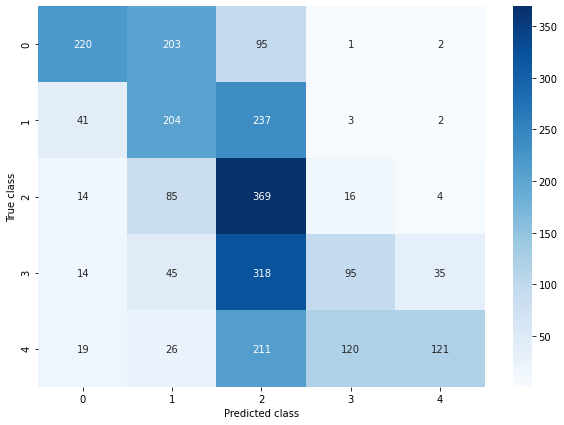

In [27]:
## Función test dato  
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# El metodo predict devuelve array con predicciones, las labels del test data y las métricas del test

#Aleman 
predictions,labels, metrics = trainer.predict(test_data)  

matrix = confusion_matrix(labels, predictions.argmax(axis=1))

plt.figure(figsize = (10,7))
## Confusion matrix with counts
sns.heatmap(matrix, annot=True,cmap='Blues',fmt='g')

#sns.heatmap(matrix/np.sum(matrix), annot=True, 
#          fmt='.2%', cmap='Oranges')
plt.xlabel("Predicted class")
plt.ylabel("True class") 

clas_report = classification_report(labels, predictions.argmax(axis=1))

print(clas_report)
print(metrics)

              precision    recall  f1-score   support

           0       0.65      0.60      0.62       498
           1       0.45      0.27      0.34       497
           2       0.37      0.59      0.46       503
           3       0.43      0.34      0.38       497
           4       0.59      0.65      0.62       505

    accuracy                           0.49      2500
   macro avg       0.50      0.49      0.49      2500
weighted avg       0.50      0.49      0.49      2500

{'eval_loss': 1.1456836462020874, 'eval_accuracy': 0.492, 'eval_f1': 0.4854591563922186, 'eval_precision': 0.5013836550201961, 'eval_recall': 0.492, 'eval_runtime': 44.3119, 'eval_samples_per_second': 56.418, 'test_mem_cpu_alloc_delta': 167727, 'test_mem_gpu_alloc_delta': 0, 'test_mem_cpu_peaked_delta': 770680, 'test_mem_gpu_peaked_delta': 773972480}


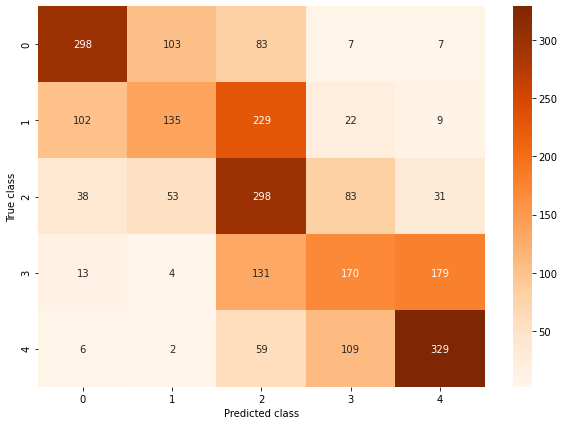

In [29]:
#Test Dato español  

path3 = "amazonES_test.csv"
df_test = pd.read_csv(path3)
df_test = df_test

test_encodings = tokenizer(df_test.text_title.values.tolist(), #truncation=True, padding=True,
      add_special_tokens=True,
      truncation=True,
      max_length=MAX_LENGTH,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt')

test_labels = df_test.star_rating.values
test_data_ES = GPReviewDataset(test_encodings, torch.from_numpy(test_labels))

## predicciones sobre valid data en ESPAÑOL
predictions,labels, metrics = trainer.predict(test_data_ES)  

# MATRIZ DE CONFUSION
matrix = confusion_matrix(labels, predictions.argmax(axis=1))

plt.figure(figsize = (10,7))
## Confusion matrix with counts
sns.heatmap(matrix, annot=True,cmap='Oranges',fmt='g')

#sns.heatmap(matrix/np.sum(matrix), annot=True, 
#          fmt='.2%', cmap='Oranges')
plt.xlabel("Predicted class")
plt.ylabel("True class") 

clas_report = classification_report(labels, predictions.argmax(axis=1))

print(clas_report)
print(metrics)


              precision    recall  f1-score   support

           0       0.64      0.54      0.58       497
           1       0.45      0.23      0.31       510
           2       0.33      0.66      0.44       507
           3       0.42      0.37      0.39       488
           4       0.68      0.53      0.59       498

    accuracy                           0.46      2500
   macro avg       0.50      0.46      0.46      2500
weighted avg       0.50      0.46      0.46      2500

{'eval_loss': 1.210147500038147, 'eval_accuracy': 0.4644, 'eval_f1': 0.4627322638535933, 'eval_precision': 0.503010212381473, 'eval_recall': 0.4644, 'eval_runtime': 44.4145, 'eval_samples_per_second': 56.288, 'test_mem_cpu_alloc_delta': 170875, 'test_mem_gpu_alloc_delta': 0, 'test_mem_cpu_peaked_delta': 763464, 'test_mem_gpu_peaked_delta': 773972480}


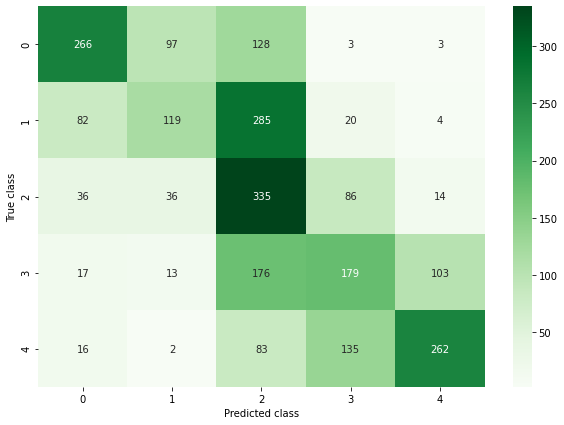

In [28]:
#Test Dato frances  

path3 = "amazonFR_test.csv"
df_test = pd.read_csv(path3)
df_test = df_test

test_encodings = tokenizer(df_test.text_title.values.tolist(), #truncation=True, padding=True,
      add_special_tokens=True,
      truncation=True,
      max_length=MAX_LENGTH,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt')

test_labels = df_test.star_rating.values
test_data_FR = GPReviewDataset(test_encodings, torch.from_numpy(test_labels))

## predicciones sobre valid data en ESPAÑOL
predictions,labels, metrics = trainer.predict(test_data_FR)  

# MATRIZ DE CONFUSION
matrix = confusion_matrix(labels, predictions.argmax(axis=1))

plt.figure(figsize = (10,7))
## Confusion matrix with counts
sns.heatmap(matrix, annot=True,cmap='Greens',fmt='g')

#sns.heatmap(matrix/np.sum(matrix), annot=True, 
#          fmt='.2%', cmap='Oranges')
plt.xlabel("Predicted class")
plt.ylabel("True class") 

clas_report = classification_report(labels, predictions.argmax(axis=1))

print(clas_report)
print(metrics)



              precision    recall  f1-score   support

           0       0.64      0.81      0.71       480
           1       0.63      0.46      0.53       530
           2       0.55      0.62      0.59       501
           3       0.64      0.56      0.60       479
           4       0.77      0.77      0.77       510

    accuracy                           0.64      2500
   macro avg       0.64      0.65      0.64      2500
weighted avg       0.64      0.64      0.64      2500

{'eval_loss': 0.8095430731773376, 'eval_accuracy': 0.6428, 'eval_f1': 0.6382253307109252, 'eval_precision': 0.6445252633266849, 'eval_recall': 0.6428, 'eval_runtime': 43.6054, 'eval_samples_per_second': 57.332, 'test_mem_cpu_alloc_delta': 172534, 'test_mem_gpu_alloc_delta': 0, 'test_mem_cpu_peaked_delta': 769757, 'test_mem_gpu_peaked_delta': 773972480}


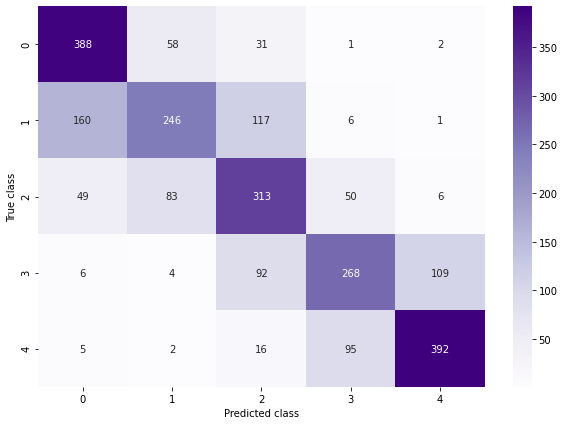

In [30]:
#Test Dato inglés (idioma de entrenamiento) 

path3 = "amazonEN_test.csv"
df_test = pd.read_csv(path3)
df_test = df_test

test_encodings = tokenizer(df_test.text_title.values.tolist(), #truncation=True, padding=True,
      add_special_tokens=True,
      truncation=True,
      max_length=MAX_LENGTH,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt')

test_labels = df_test.star_rating.values
test_data_EN = GPReviewDataset(test_encodings, torch.from_numpy(test_labels))

## predicciones sobre valid data en ESPAÑOL
predictions,labels, metrics = trainer.predict(test_data_EN)  

# MATRIZ DE CONFUSION
matrix = confusion_matrix(labels, predictions.argmax(axis=1))

plt.figure(figsize = (10,7))
## Confusion matrix with counts
sns.heatmap(matrix, annot=True,cmap='Purples',fmt='g')

#sns.heatmap(matrix/np.sum(matrix), annot=True, 
#          fmt='.2%', cmap='Oranges')
plt.xlabel("Predicted class")
plt.ylabel("True class") 

clas_report = classification_report(labels, predictions.argmax(axis=1))

print(clas_report)
print(metrics)

## Save Model

In [ ]:
!ls drive/MyDrive/TFG_1/Modelos_entrenados/

In [ ]:
# saving the fine tuned model & tokenizer
model_path = "drive/MyDrive/TFG_1/Modelos_entrenados/Rating_text_title_mBERT"
trainer.save_model(model_path)
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

# mBertForSequenceClassification - RATING
- Clasificación Rating a partir de review_body + titulo + categoria

In [15]:
RANDOM_SEED=8
MAX_LENGTH=260


## CLASES DEL CLASIFICADOR 

class_names = ['0','1','2','3','4'] 
#class_names = ['0','1'] 
#class_names = ['1']

In [16]:
#TOKENIZAMOS LOS DATAFRAMES

train_encodings = tokenizer(df_train.text_title_cat.values.tolist(), #truncation=True, padding=True,
      add_special_tokens=True,
      truncation=True,
      max_length=MAX_LENGTH,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt')

val_encodings = tokenizer(df_valid.text_title_cat.values.tolist(), #truncation=True, padding=True,
      add_special_tokens=True,
      truncation=True,
      max_length=MAX_LENGTH,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt')

test_encodings = tokenizer(df_test.text_title_cat.values.tolist(), #truncation=True, padding=True,
      add_special_tokens=True,
      truncation=True,
      max_length=MAX_LENGTH,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt')

In [17]:
class GPReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [18]:
train_labels = df_train.star_rating.values
val_labels = df_valid.star_rating.values
test_labels = df_test.star_rating.values

In [19]:
train_data = GPReviewDataset(train_encodings, torch.from_numpy(train_labels))
val_data = GPReviewDataset(val_encodings, torch.from_numpy(val_labels))
test_data = GPReviewDataset(test_encodings, torch.from_numpy(test_labels))

In [20]:
model = BertForSequenceClassification.from_pretrained(
    PRE_TRAINED_MODEL_NAME, # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = len(class_names), # The number of output labels--2 for binary classification.  si pones num_labels=1 hace MSE LOSS
    output_attentions = False, # Whether the model returns attentions weights. --> importante para la visualización de los pesos de atención
    output_hidden_states = False ,# Whether the model returns all hidden-states.   
    vocab_size=tokenizer.vocab_size)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

## Training

In [22]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [23]:
model_dir="./"

from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir = model_dir +  'prueba/results',          # output directory
    overwrite_output_dir = True,
    evaluation_strategy='epoch',
    num_train_epochs=1,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir = model_dir +  'prueba/logs',            # directory for storing logs
    logging_steps=10,
    load_best_model_at_end = True,
    #report_to = 'wandb',           # enable logging to W&B
    run_name = 'EN-body_title_cat-rating'   # name of the W&B run

)

trainer = Trainer(
    model = model,                         # the instantiated 🤗 Transformers model to be trained
    args = training_args,                  # training arguments, defined above
    train_dataset = train_data,            # training dataset
    eval_dataset = val_data,             # evaluation dataset
    compute_metrics=compute_metrics             
)

trainer.train()

wandb: wandb version 0.10.24 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch,Training Loss,Validation Loss


RuntimeError: Caught RuntimeError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/torch/nn/parallel/parallel_apply.py", line 61, in _worker
    output = module(*input, **kwargs)
  File "/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/torch/nn/modules/module.py", line 727, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/transformers/models/bert/modeling_bert.py", line 1510, in forward
    return_dict=return_dict,
  File "/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/torch/nn/modules/module.py", line 727, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/transformers/models/bert/modeling_bert.py", line 981, in forward
    return_dict=return_dict,
  File "/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/torch/nn/modules/module.py", line 727, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/transformers/models/bert/modeling_bert.py", line 575, in forward
    output_attentions,
  File "/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/torch/nn/modules/module.py", line 727, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/transformers/models/bert/modeling_bert.py", line 497, in forward
    self.feed_forward_chunk, self.chunk_size_feed_forward, self.seq_len_dim, attention_output
  File "/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/transformers/modeling_utils.py", line 1819, in apply_chunking_to_forward
    return forward_fn(*input_tensors)
  File "/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/transformers/models/bert/modeling_bert.py", line 508, in feed_forward_chunk
    intermediate_output = self.intermediate(attention_output)
  File "/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/torch/nn/modules/module.py", line 727, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/transformers/models/bert/modeling_bert.py", line 412, in forward
    hidden_states = self.intermediate_act_fn(hidden_states)
  File "/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/torch/nn/functional.py", line 1383, in gelu
    return torch._C._nn.gelu(input)
RuntimeError: CUDA out of memory. Tried to allocate 196.00 MiB (GPU 0; 11.17 GiB total capacity; 9.97 GiB already allocated; 2.81 MiB free; 10.84 GiB reserved in total by PyTorch)


In [ ]:
model_path = "Chek1mv_multi_3"
trainer.save_model(model_path)
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

## Evaluation en inglés

In [ ]:
trainer.evaluate()

## Test en otros idiomas

In [ ]:
## Función test dato  
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# El metodo predict devuelve array con predicciones, las labels del test data y las métricas del test

#Aleman 
predictions,labels, metrics = trainer.predict(test_data)  

matrix = confusion_matrix(labels, predictions.argmax(axis=1))

plt.figure(figsize = (10,7))
## Confusion matrix with counts
sns.heatmap(matrix, annot=True,cmap='Blues',fmt='g')

#sns.heatmap(matrix/np.sum(matrix), annot=True, 
#          fmt='.2%', cmap='Oranges')
plt.xlabel("Predicted class")
plt.ylabel("True class") 

clas_report = classification_report(labels, predictions.argmax(axis=1))

print(clas_report)
print(metrics)

In [ ]:
#Test Dato español  

path3 = "amazonES_test.csv"
df_test = pd.read_csv(path3)
df_test = df_test

test_encodings = tokenizer(df_test.text_title.values.tolist(), #truncation=True, padding=True,
      add_special_tokens=True,
      truncation=True,
      max_length=MAX_LENGTH,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt')

test_labels = df_test.star_rating.values
test_data_ES = GPReviewDataset(test_encodings, torch.from_numpy(test_labels))

## predicciones sobre valid data en ESPAÑOL
predictions,labels, metrics = trainer.predict(test_data_ES)  

# MATRIZ DE CONFUSION
matrix = confusion_matrix(labels, predictions.argmax(axis=1))

plt.figure(figsize = (10,7))
## Confusion matrix with counts
sns.heatmap(matrix, annot=True,cmap='Oranges',fmt='g')

#sns.heatmap(matrix/np.sum(matrix), annot=True, 
#          fmt='.2%', cmap='Oranges')
plt.xlabel("Predicted class")
plt.ylabel("True class") 

clas_report = classification_report(labels, predictions.argmax(axis=1))

print(clas_report)
print(metrics)

In [ ]:
#Test Dato frances  

path3 = "amazonFR_test.csv"
df_test = pd.read_csv(path3)
df_test = df_test

test_encodings = tokenizer(df_test.text_title.values.tolist(), #truncation=True, padding=True,
      add_special_tokens=True,
      truncation=True,
      max_length=MAX_LENGTH,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt')

test_labels = df_test.star_rating.values
test_data_FR = GPReviewDataset(test_encodings, torch.from_numpy(test_labels))

## predicciones sobre valid data en ESPAÑOL
predictions,labels, metrics = trainer.predict(test_data_FR)  

# MATRIZ DE CONFUSION
matrix = confusion_matrix(labels, predictions.argmax(axis=1))

plt.figure(figsize = (10,7))
## Confusion matrix with counts
sns.heatmap(matrix, annot=True,cmap='Greens',fmt='g')

#sns.heatmap(matrix/np.sum(matrix), annot=True, 
#          fmt='.2%', cmap='Oranges')
plt.xlabel("Predicted class")
plt.ylabel("True class") 

clas_report = classification_report(labels, predictions.argmax(axis=1))

print(clas_report)
print(metrics)

## Visualización de la atención con BertViz 

In [ ]:
!pip install bertviz

In [ ]:
inputs = tokenizer.encode("I like this product so much", return_tensors='pt')
outputs = model(inputs)
attention = outputs[-1]                      # Output includes attention weights when output_attentions=True
tokens = tokenizer.convert_ids_to_tokens(inputs[0]) 

## Save Model

In [ ]:
!ls drive/MyDrive/TFG_1/Modelos_entrenados/

In [ ]:
# saving the fine tuned model & tokenizer
model_path = "drive/MyDrive/TFG_1/Modelos_entrenados/Rating_text_title_cat_mBERT"
trainer.save_model(model_path)
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

# BertForSequenceClassification - CATEGORÍA

- Clasificación de categorias de productos a partir del review_body

In [16]:
RANDOM_SEED=8
MAX_LENGTH=260


## CLASES DEL CLASIFICADOR 

class_names = df_train.product_category.unique().tolist()

In [17]:
#TOKENIZAMOS LOS DATAFRAMES

train_encodings = tokenizer(df_train.review_body.values.tolist(), #truncation=True, padding=True,
      add_special_tokens=True,
      truncation=True,
      max_length=MAX_LENGTH,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt')

val_encodings = tokenizer(df_valid.review_body.values.tolist(), #truncation=True, padding=True,
      add_special_tokens=True,
      truncation=True,
      max_length=MAX_LENGTH,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt')

test_encodings = tokenizer(df_test.review_body.values.tolist(), #truncation=True, padding=True,
      add_special_tokens=True,
      truncation=True,
      max_length=MAX_LENGTH,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt')

In [18]:
class GPReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [19]:
train_labels = df_train.product_category_cod.values
val_labels = df_valid.product_category_cod.values
test_labels = df_test.product_category_cod.values

In [20]:
train_data = GPReviewDataset(train_encodings, torch.from_numpy(train_labels))
val_data = GPReviewDataset(val_encodings, torch.from_numpy(val_labels))
test_data = GPReviewDataset(test_encodings, torch.from_numpy(test_labels))

In [21]:
model = BertForSequenceClassification.from_pretrained(
    PRE_TRAINED_MODEL_NAME, # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = len(class_names), # The number of output labels--2 for binary classification.  si pones num_labels=1 hace MSE LOSS
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False ,# Whether the model returns all hidden-states.   
    vocab_size=tokenizer.vocab_size)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

## Training

In [24]:
model_dir="./"

from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir = model_dir +  'prueba/results',          # output directory
    overwrite_output_dir = True,
    evaluation_strategy='epoch',
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir = model_dir +  'prueba/logs',            # directory for storing logs
    logging_steps=10,
    load_best_model_at_end = True,
    #report_to = 'wandb',           # enable logging to W&B
    run_name = 'EN-body- category'   # name of the W&B run
)

trainer = Trainer(
    model = model,                         # the instantiated 🤗 Transformers model to be trained
    args = training_args,                  # training arguments, defined above
    train_dataset = train_data,         # training dataset
    eval_dataset = val_data,            # evaluation dataset
    compute_metrics = compute_metrics             
)

trainer.train()

wandb: wandb version 0.10.24 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
1,1.685700,1.828429,0.481200,0.466035,0.491996,0.481200,44.200900,56.560000
2,1.526600,1.691959,0.519600,0.512335,0.519157,0.519600,43.878300,56.976000
3,1.507700,1.676065,0.531200,0.518490,0.518731,0.531200,44.177200,56.590000


TrainOutput(global_step=18750, training_loss=1.7168937803649902, metrics={'train_runtime': 35116.6316, 'train_samples_per_second': 0.534, 'total_flos': 1.66493133144e+17, 'epoch': 3.0, 'init_mem_cpu_alloc_delta': 67058, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 18306, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 40813940, 'train_mem_gpu_alloc_delta': 2885237248, 'train_mem_cpu_peaked_delta': 734426769, 'train_mem_gpu_peaked_delta': 3937049088})

In [25]:
model_path = "Chek1mv_multi_4"
trainer.save_model(model_path)
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('Chek1mv_multi_4/tokenizer_config.json',
 'Chek1mv_multi_4/special_tokens_map.json',
 'Chek1mv_multi_4/vocab.txt',
 'Chek1mv_multi_4/added_tokens.json')

## Evaluation

In [26]:
trainer.evaluate()

wandb: WARNING Step must only increase in log calls.  Step 18750 < 18751; dropping {'eval/loss': 1.6760646104812622, 'eval/accuracy': 0.5312, 'eval/f1': 0.5184899719621034, 'eval/precision': 0.5187306491375294, 'eval/recall': 0.5312, 'eval/runtime': 43.6083, 'eval/samples_per_second': 57.329, 'train/epoch': 3.0}.


{'eval_loss': 1.6760646104812622,
 'eval_accuracy': 0.5312,
 'eval_f1': 0.5184899719621034,
 'eval_precision': 0.5187306491375294,
 'eval_recall': 0.5312,
 'eval_runtime': 43.6083,
 'eval_samples_per_second': 57.329,
 'epoch': 3.0,
 'eval_mem_cpu_alloc_delta': 440003,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_cpu_peaked_delta': 495649,
 'eval_mem_gpu_peaked_delta': 774225408}

              precision    recall  f1-score   support

           0       0.27      0.28      0.28       114
           1       0.23      0.24      0.24        62
           2       0.38      0.20      0.27        54
           3       0.60      0.36      0.45       111
           4       0.38      0.56      0.46        55
           5       0.12      0.31      0.18        16
           6       0.27      0.44      0.34        27
           7       0.74      0.72      0.73        39
           8       0.15      0.11      0.13        96
           9       0.40      0.17      0.23       103
          10       0.08      0.03      0.04        78
          11       0.24      0.30      0.26        30
          12       0.18      0.12      0.15       338
          13       0.10      0.06      0.07       163
          14       0.00      0.00      0.00        13
          15       0.24      0.12      0.16        33
          16       0.07      0.11      0.08        74
          17       0.22    

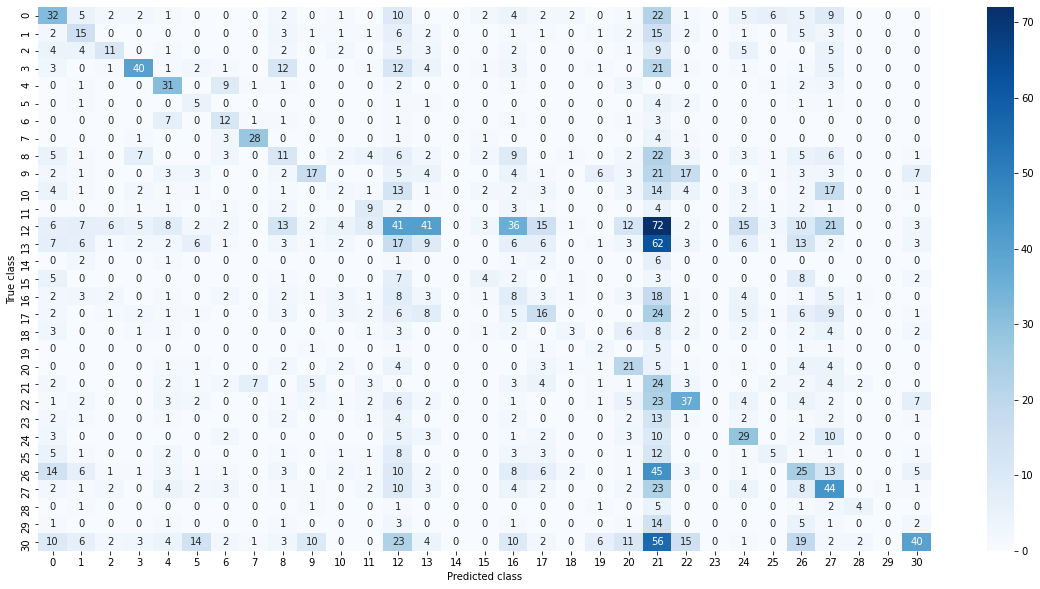

In [34]:
## Función test dato  
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# El metodo predict devuelve array con predicciones, las labels del test data y las métricas del test

#Aleman 
path3 = "amazonDE_test.csv"
df_test = pd.read_csv(path3)
df_test = df_test

test_encodings = tokenizer(df_test.text_title.values.tolist(), #truncation=True, padding=True,
      add_special_tokens=True,
      truncation=True,
      max_length=MAX_LENGTH,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt')

test_labels = df_test.product_category_cod.values
test_data_ES = GPReviewDataset(test_encodings, torch.from_numpy(test_labels))

predictions,labels, metrics = trainer.predict(test_data)  

matrix = confusion_matrix(labels, predictions.argmax(axis=1))

plt.figure(figsize = (20,10))
## Confusion matrix with counts
sns.heatmap(matrix, annot=True,cmap='Blues',fmt='g')

#sns.heatmap(matrix/np.sum(matrix), annot=True, 
#          fmt='.2%', cmap='Oranges')
plt.xlabel("Predicted class")
plt.ylabel("True class") 

clas_report = classification_report(labels, predictions.argmax(axis=1))

print(clas_report)
print(metrics)

              precision    recall  f1-score   support

           0       0.23      0.19      0.21        75
           1       0.20      0.19      0.20        93
           2       0.18      0.08      0.11        49
           3       0.19      0.28      0.23        78
           4       0.60      0.46      0.52        61
           5       0.33      0.30      0.31        44
           6       0.46      0.52      0.49        21
           7       0.00      0.00      0.00        59
           8       0.04      0.05      0.04       136
           9       0.02      0.02      0.02        57
          10       0.00      0.00      0.00        16
          11       0.19      0.03      0.05       354
          12       0.06      0.11      0.07       146
          13       0.00      0.00      0.00        21
          14       0.00      0.00      0.00        30
          15       0.00      0.00      0.00        87
          16       0.04      0.12      0.06        52
          17       0.00    

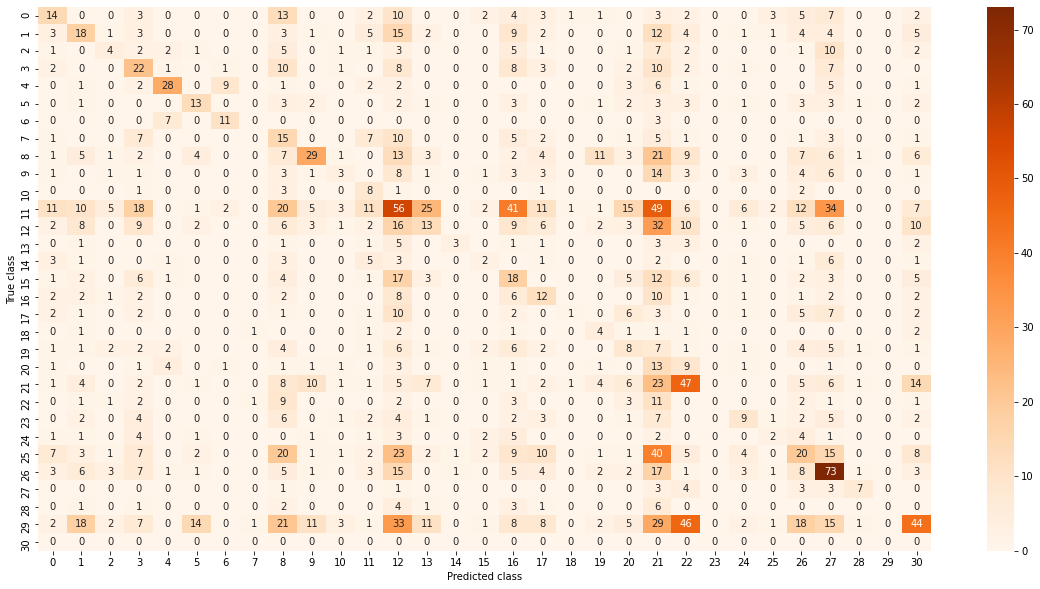

In [32]:
#Test Dato español  

path3 = "amazonES_test.csv"
df_test = pd.read_csv(path3)
df_test = df_test

test_encodings = tokenizer(df_test.text_title.values.tolist(), #truncation=True, padding=True,
      add_special_tokens=True,
      truncation=True,
      max_length=MAX_LENGTH,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt')

test_labels = df_test.product_category_cod.values
test_data_ES = GPReviewDataset(test_encodings, torch.from_numpy(test_labels))

## predicciones sobre valid data en ESPAÑOL
predictions,labels, metrics = trainer.predict(test_data_ES)  

# MATRIZ DE CONFUSION
matrix = confusion_matrix(labels, predictions.argmax(axis=1))

plt.figure(figsize = (20,10))
## Confusion matrix with counts
sns.heatmap(matrix, annot=True,cmap='Oranges',fmt='g')

#sns.heatmap(matrix/np.sum(matrix), annot=True, 
#          fmt='.2%', cmap='Oranges')
plt.xlabel("Predicted class")
plt.ylabel("True class") 

clas_report = classification_report(labels, predictions.argmax(axis=1))

print(clas_report)
print(metrics)

              precision    recall  f1-score   support

           0       0.21      0.21      0.21        72
           1       0.19      0.17      0.18        78
           2       0.17      0.03      0.05        62
           3       0.31      0.31      0.31        98
           4       0.81      0.52      0.64       103
           5       0.16      0.19      0.18        26
           6       0.37      0.76      0.50        17
           7       0.00      0.00      0.00        79
           8       0.03      0.04      0.04       112
           9       0.02      0.02      0.02        59
          10       0.00      0.00      0.00        13
          11       0.22      0.06      0.10       365
          12       0.08      0.14      0.10       146
          13       0.00      0.00      0.00        16
          14       0.00      0.00      0.00        34
          15       0.00      0.00      0.00       100
          16       0.04      0.08      0.05        64
          17       0.00    

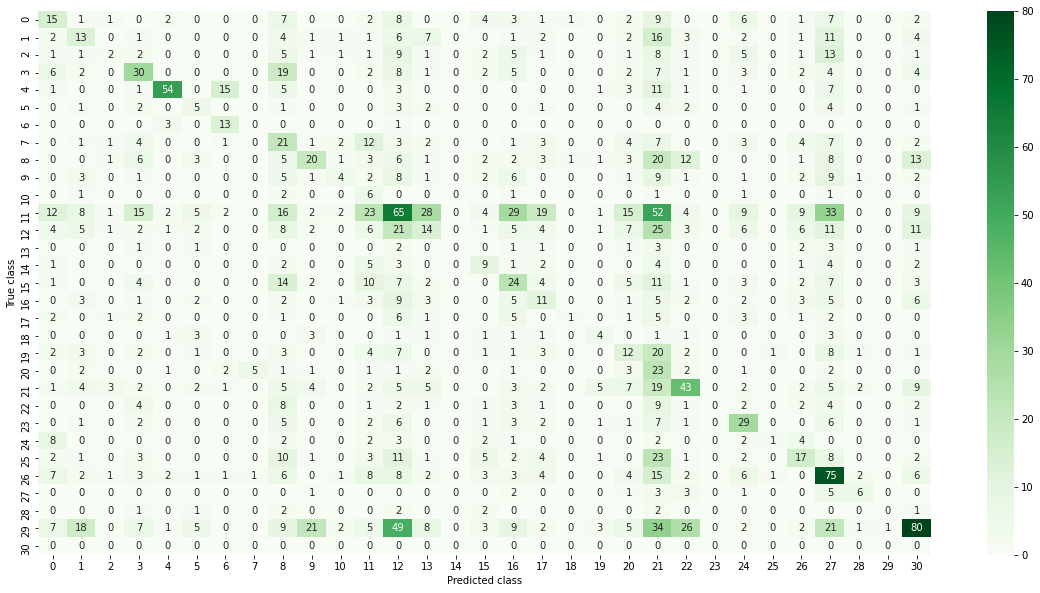

In [33]:
#Test Dato frances  

path3 = "amazonFR_test.csv"
df_test = pd.read_csv(path3)
df_test = df_test

test_encodings = tokenizer(df_test.text_title.values.tolist(), #truncation=True, padding=True,
      add_special_tokens=True,
      truncation=True,
      max_length=MAX_LENGTH,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt')

test_labels = df_test.product_category_cod.values
test_data_FR = GPReviewDataset(test_encodings, torch.from_numpy(test_labels))

## predicciones sobre valid data en ESPAÑOL
predictions,labels, metrics = trainer.predict(test_data_FR)  

# MATRIZ DE CONFUSION
matrix = confusion_matrix(labels, predictions.argmax(axis=1))

plt.figure(figsize = (20,10))
## Confusion matrix with counts
sns.heatmap(matrix, annot=True,cmap='Greens',fmt='g')

#sns.heatmap(matrix/np.sum(matrix), annot=True, 
#          fmt='.2%', cmap='Oranges')
plt.xlabel("Predicted class")
plt.ylabel("True class") 

clas_report = classification_report(labels, predictions.argmax(axis=1))

print(clas_report)
print(metrics)

## Save Model

In [ ]:
!ls drive/MyDrive/TFG_1/Modelos_entrenados/

In [ ]:
# saving the fine tuned model & tokenizer
model_path = "drive/MyDrive/TFG_1/Modelos_entrenados/Category_text_mBERT"
trainer.save_model(model_path)
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

# BertForSequenceClassification - CATEGORÍA

- Clasificación de categorias de productos a partir del review_body + titulo

In [13]:
RANDOM_SEED=8
MAX_LENGTH=260


## CLASES DEL CLASIFICADOR 

class_names = df_train.product_category.unique().tolist()

In [14]:
#TOKENIZAMOS LOS DATAFRAMES

train_encodings = tokenizer(df_train.text_title.values.tolist(), #truncation=True, padding=True,
      add_special_tokens=True,
      truncation=True,
      max_length=MAX_LENGTH,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt')

val_encodings = tokenizer(df_valid.text_title.values.tolist(), #truncation=True, padding=True,
      add_special_tokens=True,
      truncation=True,
      max_length=MAX_LENGTH,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt')

test_encodings = tokenizer(df_test.text_title.values.tolist(), #truncation=True, padding=True,
      add_special_tokens=True,
      truncation=True,
      max_length=MAX_LENGTH,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt')

In [15]:
class GPReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [16]:
train_labels = df_train.product_category_cod.values
val_labels = df_valid.product_category_cod.values
test_labels = df_test.product_category_cod.values

In [17]:
train_data = GPReviewDataset(train_encodings, torch.from_numpy(train_labels))
val_data = GPReviewDataset(val_encodings, torch.from_numpy(val_labels))
test_data = GPReviewDataset(test_encodings, torch.from_numpy(test_labels))

In [18]:
model = BertForSequenceClassification.from_pretrained(
    PRE_TRAINED_MODEL_NAME, # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = len(class_names), # The number of output labels--2 for binary classification.  si pones num_labels=1 hace MSE LOSS
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False ,# Whether the model returns all hidden-states.   
    vocab_size=tokenizer.vocab_size)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

## Training

In [22]:
model_dir="./"

from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir = model_dir +  'prueba/results',          # output directory
    overwrite_output_dir = True,
    evaluation_strategy='epoch',
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir = model_dir +  'prueba/logs',            # directory for storing logs
    logging_steps=10,
    load_best_model_at_end = True,
    #report_to = 'wandb',           # enable logging to W&B
    run_name = 'EN-body_title - category'   # name of the W&B run
)


trainer = Trainer(
    model = model,                         # the instantiated 🤗 Transformers model to be trained
    args = training_args,                  # training arguments, defined above
    train_dataset = train_data,         # training dataset
    eval_dataset = val_data,
    compute_metrics = compute_metrics            # evaluation dataset
)

trainer.train()

wandb: wandb version 0.10.24 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
1,1.608800,1.779407,0.500800,0.488086,0.503644,0.500800,44.200100,56.561000
2,1.561500,1.659835,0.522400,0.512957,0.519077,0.522400,43.921000,56.920000
3,1.453400,1.647056,0.533200,0.523036,0.528922,0.533200,43.907600,56.938000


TrainOutput(global_step=18750, training_loss=1.6740030372111003, metrics={'train_runtime': 35180.5629, 'train_samples_per_second': 0.533, 'total_flos': 1.66493133144e+17, 'epoch': 3.0, 'init_mem_cpu_alloc_delta': 69622, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 18306, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 40834375, 'train_mem_gpu_alloc_delta': 2885237248, 'train_mem_cpu_peaked_delta': 734433632, 'train_mem_gpu_peaked_delta': 3937049088})

In [24]:
model_path = "Chek1mv_multi5"
trainer.save_model(model_path)
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('Chek1mv_multi5/tokenizer_config.json',
 'Chek1mv_multi5/special_tokens_map.json',
 'Chek1mv_multi5/vocab.txt',
 'Chek1mv_multi5/added_tokens.json')

## Evaluation inglés

In [23]:
trainer.evaluate()

wandb: WARNING Step must only increase in log calls.  Step 18750 < 18751; dropping {'eval/loss': 1.6470561027526855, 'eval/accuracy': 0.5332, 'eval/f1': 0.52303597433921, 'eval/precision': 0.5289224713480125, 'eval/recall': 0.5332, 'eval/runtime': 43.3442, 'eval/samples_per_second': 57.678, 'train/epoch': 3.0}.


{'eval_loss': 1.6470561027526855,
 'eval_accuracy': 0.5332,
 'eval_f1': 0.52303597433921,
 'eval_precision': 0.5289224713480125,
 'eval_recall': 0.5332,
 'eval_runtime': 43.3442,
 'eval_samples_per_second': 57.678,
 'epoch': 3.0,
 'eval_mem_cpu_alloc_delta': 439597,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_cpu_peaked_delta': 492638,
 'eval_mem_gpu_peaked_delta': 774225408}

              precision    recall  f1-score   support

           0       0.28      0.23      0.25       114
           1       0.19      0.18      0.18        62
           2       0.45      0.17      0.24        54
           3       0.41      0.38      0.39       111
           4       0.34      0.53      0.41        55
           5       0.14      0.38      0.21        16
           6       0.29      0.52      0.37        27
           7       0.68      0.77      0.72        39
           8       0.14      0.10      0.12        96
           9       0.28      0.10      0.14       103
          10       0.07      0.01      0.02        78
          11       0.20      0.37      0.26        30
          12       0.20      0.16      0.18       338
          13       0.14      0.08      0.10       163
          14       0.00      0.00      0.00        13
          15       0.19      0.12      0.15        33
          16       0.07      0.16      0.10        74
          17       0.28    

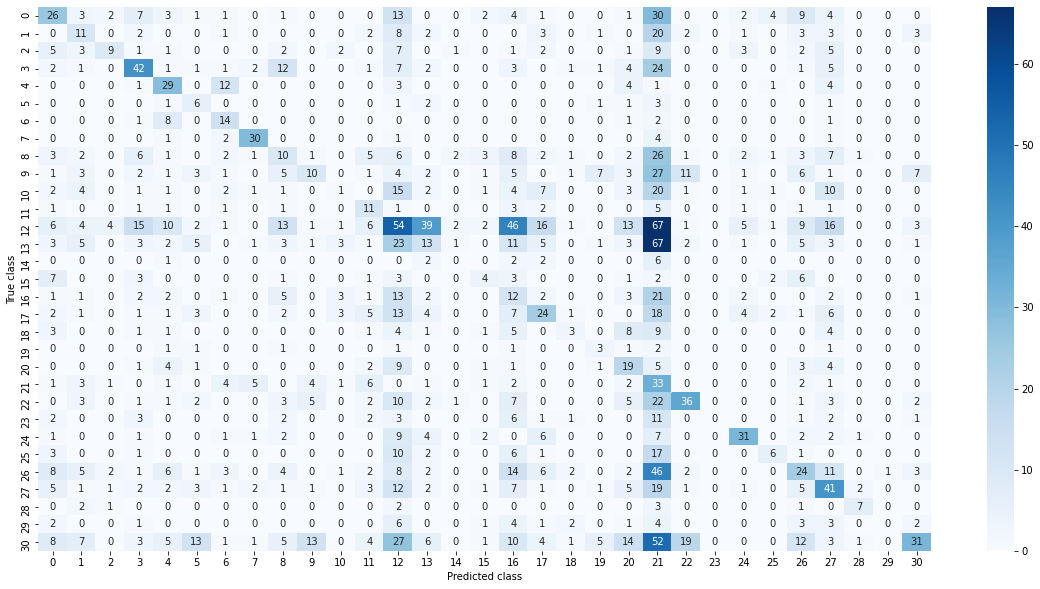

In [25]:
## Función test dato  
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# El metodo predict devuelve array con predicciones, las labels del test data y las métricas del test

#Aleman 
path3 = "amazonDE_test.csv"
df_test = pd.read_csv(path3)
df_test = df_test

test_encodings = tokenizer(df_test.text_title.values.tolist(), #truncation=True, padding=True,
      add_special_tokens=True,
      truncation=True,
      max_length=MAX_LENGTH,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt')

test_labels = df_test.product_category_cod.values
test_data_ES = GPReviewDataset(test_encodings, torch.from_numpy(test_labels))

predictions,labels, metrics = trainer.predict(test_data)  

matrix = confusion_matrix(labels, predictions.argmax(axis=1))

plt.figure(figsize = (20,10))
## Confusion matrix with counts
sns.heatmap(matrix, annot=True,cmap='Blues',fmt='g')

#sns.heatmap(matrix/np.sum(matrix), annot=True, 
#          fmt='.2%', cmap='Oranges')
plt.xlabel("Predicted class")
plt.ylabel("True class") 

clas_report = classification_report(labels, predictions.argmax(axis=1))

print(clas_report)
print(metrics)

              precision    recall  f1-score   support

           0       0.24      0.16      0.19        75
           1       0.26      0.17      0.21        93
           2       0.30      0.14      0.19        49
           3       0.15      0.31      0.21        78
           4       0.48      0.49      0.49        61
           5       0.26      0.23      0.24        44
           6       0.48      0.62      0.54        21
           7       0.00      0.00      0.00        59
           8       0.03      0.06      0.04       136
           9       0.02      0.02      0.02        57
          10       0.00      0.00      0.00        16
          11       0.14      0.04      0.07       354
          12       0.08      0.15      0.10       146
          13       0.00      0.00      0.00        21
          14       0.00      0.00      0.00        30
          15       0.00      0.00      0.00        87
          16       0.03      0.12      0.05        52
          17       0.03    

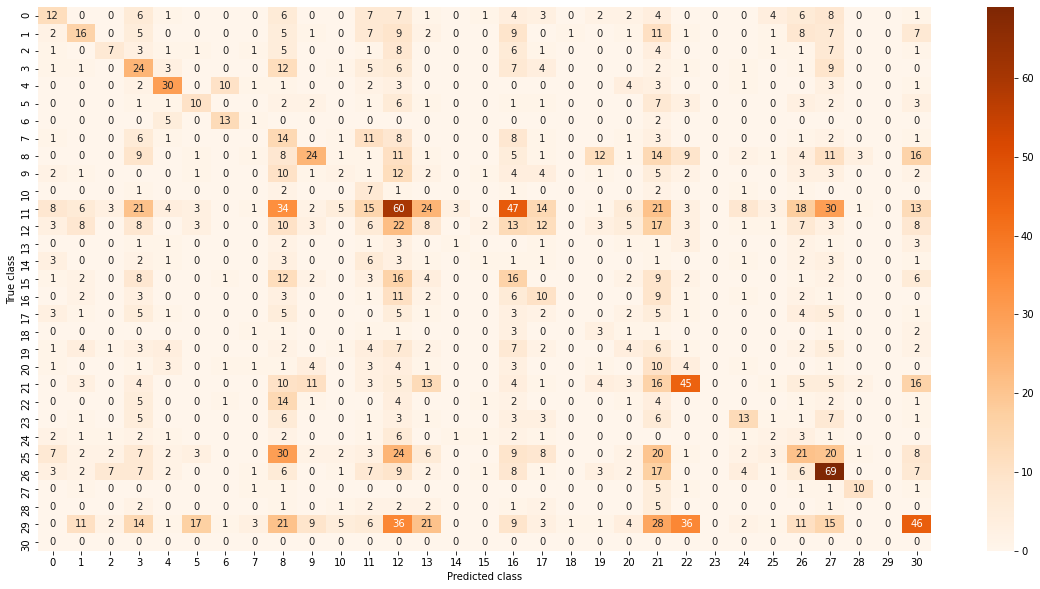

In [26]:
#Test Dato español  

path3 = "amazonES_test.csv"
df_test = pd.read_csv(path3)
df_test = df_test

test_encodings = tokenizer(df_test.text_title.values.tolist(), #truncation=True, padding=True,
      add_special_tokens=True,
      truncation=True,
      max_length=MAX_LENGTH,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt')

test_labels = df_test.product_category_cod.values
test_data_ES = GPReviewDataset(test_encodings, torch.from_numpy(test_labels))

## predicciones sobre valid data en ESPAÑOL
predictions,labels, metrics = trainer.predict(test_data_ES)  

# MATRIZ DE CONFUSION
matrix = confusion_matrix(labels, predictions.argmax(axis=1))

plt.figure(figsize = (20,10))
## Confusion matrix with counts
sns.heatmap(matrix, annot=True,cmap='Oranges',fmt='g')

#sns.heatmap(matrix/np.sum(matrix), annot=True, 
#          fmt='.2%', cmap='Oranges')
plt.xlabel("Predicted class")
plt.ylabel("True class") 

clas_report = classification_report(labels, predictions.argmax(axis=1))

print(clas_report)
print(metrics)

              precision    recall  f1-score   support

           0       0.23      0.19      0.21        72
           1       0.22      0.18      0.20        78
           2       0.40      0.10      0.16        62
           3       0.23      0.35      0.27        98
           4       0.75      0.57      0.65       103
           5       0.09      0.12      0.10        26
           6       0.47      0.88      0.61        17
           7       0.00      0.00      0.00        79
           8       0.03      0.04      0.03       112
           9       0.00      0.00      0.00        59
          10       0.00      0.00      0.00        13
          11       0.24      0.05      0.09       365
          12       0.07      0.14      0.09       146
          13       0.00      0.00      0.00        16
          14       0.00      0.00      0.00        34
          15       0.00      0.00      0.00       100
          16       0.03      0.08      0.04        64
          17       0.00    

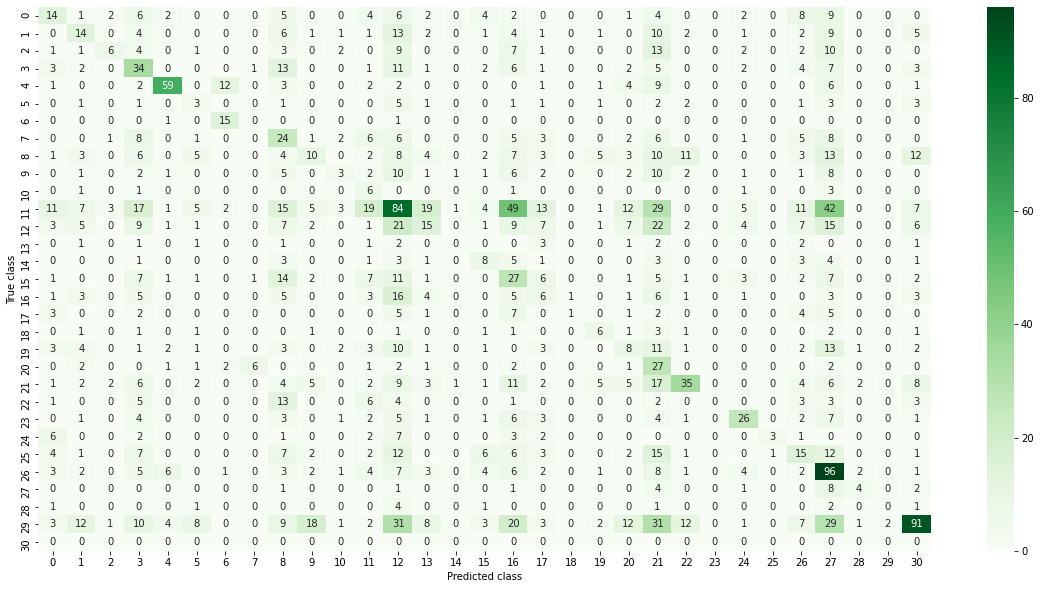

In [27]:
#Test Dato frances  

path3 = "amazonFR_test.csv"
df_test = pd.read_csv(path3)
df_test = df_test

test_encodings = tokenizer(df_test.text_title.values.tolist(), #truncation=True, padding=True,
      add_special_tokens=True,
      truncation=True,
      max_length=MAX_LENGTH,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt')

test_labels = df_test.product_category_cod.values
test_data_FR = GPReviewDataset(test_encodings, torch.from_numpy(test_labels))

## predicciones sobre valid data en ESPAÑOL
predictions,labels, metrics = trainer.predict(test_data_FR)  

# MATRIZ DE CONFUSION
matrix = confusion_matrix(labels, predictions.argmax(axis=1))

plt.figure(figsize = (20,10))
## Confusion matrix with counts
sns.heatmap(matrix, annot=True,cmap='Greens',fmt='g')

#sns.heatmap(matrix/np.sum(matrix), annot=True, 
#          fmt='.2%', cmap='Oranges')
plt.xlabel("Predicted class")
plt.ylabel("True class") 

clas_report = classification_report(labels, predictions.argmax(axis=1))

print(clas_report)
print(metrics)

              precision    recall  f1-score   support

           0       0.28      0.23      0.25       114
           1       0.19      0.18      0.18        62
           2       0.45      0.17      0.24        54
           3       0.41      0.38      0.39       111
           4       0.34      0.53      0.41        55
           5       0.14      0.38      0.21        16
           6       0.29      0.52      0.37        27
           7       0.68      0.77      0.72        39
           8       0.14      0.10      0.12        96
           9       0.28      0.10      0.14       103
          10       0.07      0.01      0.02        78
          11       0.20      0.37      0.26        30
          12       0.20      0.16      0.18       338
          13       0.14      0.08      0.10       163
          14       0.00      0.00      0.00        13
          15       0.19      0.12      0.15        33
          16       0.07      0.16      0.10        74
          17       0.28    

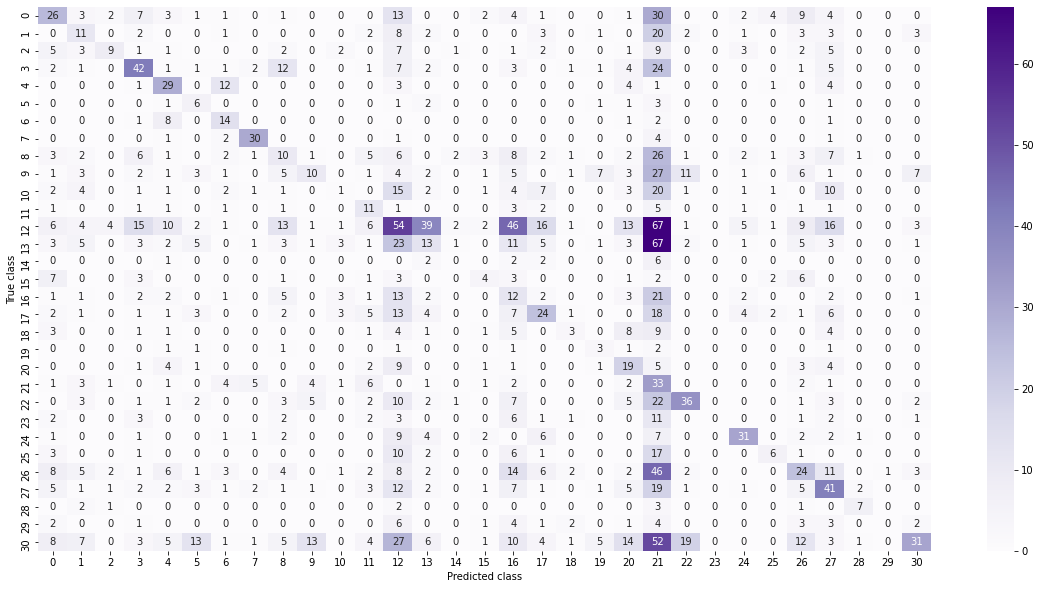

In [29]:
## Función test dato  
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# El metodo predict devuelve array con predicciones, las labels del test data y las métricas del test

#Inglés
path3 = "amazonEN_test.csv"
df_test = pd.read_csv(path3)
df_test = df_test

test_encodings = tokenizer(df_test.text_title.values.tolist(), #truncation=True, padding=True,
      add_special_tokens=True,
      truncation=True,
      max_length=MAX_LENGTH,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt')

test_labels = df_test.product_category_cod.values
test_data_ES = GPReviewDataset(test_encodings, torch.from_numpy(test_labels))

predictions,labels, metrics = trainer.predict(test_data)  

matrix = confusion_matrix(labels, predictions.argmax(axis=1))

plt.figure(figsize = (20,10))
## Confusion matrix with counts
sns.heatmap(matrix, annot=True,cmap='Purples',fmt='g')

#sns.heatmap(matrix/np.sum(matrix), annot=True, 
#          fmt='.2%', cmap='Oranges')
plt.xlabel("Predicted class")
plt.ylabel("True class") 

clas_report = classification_report(labels, predictions.argmax(axis=1))

print(clas_report)
print(metrics)

## Save Model

In [ ]:
!ls drive/MyDrive/TFG_1/Modelos_entrenados/

In [ ]:
# saving the fine tuned model & tokenizer
model_path = "drive/MyDrive/TFG_1/Modelos_entrenados/Category_text_title_mBERT"
trainer.save_model(model_path)
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)